<a href="https://colab.research.google.com/github/givasile/edinburgh-thesis/blob/master/example_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This presentation is meant to illustrate the functionalities provided by the ROMC inference method, at the ELFI package.

In [ ]:
# install dev branch of ELFI
! pip install elfi

     |████████████████████████████████| 163kB 25.2MB/s 
     |████████████████████████████████| 1.0MB 31.5MB/s 
     |████████████████████████████████| 204kB 45.6MB/s 
     |████████████████████████████████| 849kB 43.9MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 686kB 38.3MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp37-cp37m-linux_x86_64.whl size=2627012 sha256=94d5f35afe19e7eb27fbd05a686a2095eee2f4dd3003aecdb81009b01f28f750
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp37-none-any.whl size=102552 sha256=f2cce96cb1aa14604feb932d5a1fe6d191c94a4e8d8ad4acbb506db7770eb62c
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz
ERROR: distributed 2021.3.1 has requirement dask>=2021.03.0, but you'll have dask 2.30.0 which is incompatible.
 

In [ ]:
import timeit
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.stats as ss
import elfi

np.random.seed(21)

## Ground-truth posterior approximation

In [ ]:
class Prior:
    def rvs(self, size=None, random_state=None):
        # size from (BS,) -> (BS,1)
        if size is not None:
            size = np.concatenate((size, [1]))
        return ss.uniform(loc=-2.5, scale=5).rvs(size=size, random_state=random_state)

    def pdf(self, theta):
        return ss.uniform(loc=-2.5, scale=5).pdf(theta)

    def logpdf(self, theta):
        return ss.uniform(loc=-2.5, scale=5).logpdf(theta)

In [ ]:
class Likelihood:
    r"""Implements the distribution
    P(x|theta) = N(x; theta^4, 1)         if theta in [-0.5, 0.5]
                 N(x; theta + 0.5 + 0.5^4 if theta > 0.5
                 N(x; theta - 0.5 + 0.5^4 if theta < 0.5
    """

    def rvs(self, theta, seed=None):
        """Vectorized sampling from likelihood.

        """
        assert isinstance(theta, np.ndarray)
        theta = theta.astype(np.float)
        samples = np.empty_like(theta)

        c = 0.5 - 0.5 ** 4

        tmp_theta = theta[theta <= -0.5]
        samples[theta <= -0.5] = ss.norm(loc=-tmp_theta - c, scale=1).rvs(random_state=seed)
        theta[theta <= -0.5] = np.inf

        tmp_theta = theta[theta <= 0.5]
        samples[theta <= 0.5] = ss.norm(loc=tmp_theta**4, scale=1).rvs(random_state=seed)
        theta[theta <= 0.5] = np.inf

        tmp_theta = theta[theta < np.inf]
        samples[theta < np.inf] = ss.norm(loc=tmp_theta - c, scale=1).rvs(random_state=seed)
        theta[theta < np.inf] = np.inf

        assert np.allclose(theta, np.inf)
        return samples

    def pdf(self, x, theta):
        """Vectorised pdf evaluation.
        """
        assert isinstance(x, np.ndarray)
        assert isinstance(theta, np.ndarray)
        assert theta.ndim == 1
        assert x.ndim == 1

        BS = theta.shape[0]
        N = x.shape[0]
        theta = theta.astype(np.float)

        pdf_eval = np.zeros((BS))
        c = 0.5 - 0.5 ** 4

        def help_func(lim, mode):
            tmp_theta = theta[theta <= lim]
            tmp_theta = np.expand_dims(tmp_theta, -1)
            scale = np.ones_like(tmp_theta)
            if mode == 1:
                pdf_eval[theta <= lim] = np.prod(ss.norm(loc=-tmp_theta - c, scale=scale).pdf(x), 1)
            elif mode == 2:
                pdf_eval[theta <= lim] = np.prod(ss.norm(loc=tmp_theta**4, scale=scale).pdf(x), 1)
            elif mode == 3:
                pdf_eval[theta <= lim] = np.prod(ss.norm(loc=tmp_theta - c, scale=scale).pdf(x), 1)
            theta[theta <= lim] = np.inf

        big_M = 10**7
        help_func(lim=-0.5, mode=1)
        help_func(lim=0.5, mode=2)
        help_func(lim=big_M, mode=3)
        assert np.allclose(theta, np.inf)
        return pdf_eval

In [ ]:
def summary(x):
    assert isinstance(x, np.ndarray)
    if x.ndim == 1:
        return x
    elif x.ndim == 2:
        return np.prod(x, 1)


def create_factor(x):
    """Creates the function g(theta) = L(theta)*prior(theta).

    """
    lik = Likelihood()
    pr = Prior()
    def tmp_func(theta):
        return float(lik.pdf(x, np.array([theta])) * pr.pdf(theta))
    return tmp_func


def approximate_Z(func, a, b):
    """Approximates the partition function with exhaustive integration.
    """
    return integrate.quad(func, a, b)[0]


def create_gt_posterior(likelihood, prior, data, Z):
    """Returns a function that computes the gt posterior
    """
    def tmp_func(theta):
        return likelihood.pdf(data, np.array([theta])) * prior.pdf(np.array([theta])) / Z
    return tmp_func

def compute_gt_mean(pdf):
    def integrad(x):
        return x*pdf(x)
    return integrate.quad(integrad, -3, 3)

def compute_gt_variance(pdf, mean):
    def integrad(x):
        return (x**2 - mean)*pdf(x)
    return np.sqrt(integrate.quad(integrad, -3, 3))

In [ ]:
data = np.array([0.])
dim = data.shape[0]
a = -2.5  # integration left limit
b = 2.5   # integration right limit

likelihood = Likelihood()
prior = Prior()

factor = create_factor(x=data)
Z = approximate_Z(factor, a, b)
gt_posterior_pdf = create_gt_posterior(likelihood, prior, data, Z)
gt_posterior_mean = compute_gt_mean(gt_posterior_pdf)[0]
gt_posterior_var = compute_gt_variance(gt_posterior_pdf, gt_posterior_mean)[0]

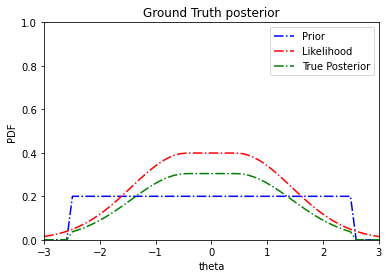

In [ ]:
plt.figure()
plt.title("Ground Truth posterior")
plt.xlim(-3, 3)
plt.xlabel("theta")
plt.ylabel("PDF")
plt.ylim(0, 1)

# plot prior
theta = np.linspace(-3, 3, 60)
y = prior.pdf(theta)
plt.plot(theta, y, 'b-.', label='Prior')

# plot likelihood
y = likelihood.pdf(x=data, theta=theta)
plt.plot(theta, y, 'r-.', label='Likelihood')

# plot posterior
y = np.squeeze(np.array([gt_posterior_pdf(th) for th in theta]))
plt.plot(theta, y, 'g-.', label="True Posterior")

plt.legend()
plt.show(block=False)

## Define the model at elfi

In [ ]:
def simulator(theta, dim, batch_size=10000, random_state=None):
    likelihood = Likelihood()
    theta = np.repeat(theta, dim, -1)
    return likelihood.rvs(theta, seed=random_state)


elfi.new_model("1D_example")
elfi_prior = elfi.Prior(Prior(), name="theta")
elfi_simulator = elfi.Simulator(simulator, elfi_prior, dim, observed=np.expand_dims(data, 0), name="simulator")
dist = elfi.Distance('euclidean', elfi_simulator, name="dist")

In [ ]:
bounds = [(-2.5, 2.5)]
dim = data.shape[-1]

# Defines the ROMC inference method
romc = elfi.ROMC(dist, bounds)

**Functionalities of ROMC**

We can split the functionalities of the ROMC inference method, in three categories; the training (fitting) part, the inference part.

**Training (Fitting) part**

In the training part, the algorithm (i) transforms the random sampling DAG into deterministic optimisation problems by sampling the nuisance variables (ii) solves the optimisation problems and (iii) estimates the Bounding Box areas around the solutions. For the training part, the 3 following functionalities are exposed:

* **solve_problems**(n1, seed, use_gp): draws n1 nuisance variables and then defines and solves n1 optimisation problems. If use_gp==True, Bayesian Optimization is used instead of gradient_based and a Gaussian Process is fitted as distance model.
* **estimate_regions**(eps, region_mode): creates square bounding boxes around the solutions $\theta_*$ of the optimisation problems. If solve_problems is called with use_gp=True, region mode must be "gp". 
* **fit_posterior**(n1, eps, region_mode, seed): combines both steps above in a single function. The argument passed at region mode defines whether GP will be used.

**Inference part**

Afterwards, the user may ask three separate things from the estimated posterior:

* **sample**(n2): the posterior asks for n2 **weighted** samples per optimisation problem. In total, the method will provide $n_1*n_2$ samples, alongside with their weights.
* **compute_expectation**(h): h is a function that maps the samples to an output. This routine approximates $E_{P(\theta|data)}[h(\theta)]$ as $\frac{\sum_i h(\theta_i)w_i}{\sum_i w_i}$
* **eval_unnorm_posterior**($\theta$): this method evaluates the posterior at the point $\theta$, as $p(\theta|data) \approx p(\theta) \sum_i \mathbb{1}_{C_\epsilon^{(i)}}(\theta)$. 
* **eval_posterior**($\theta$): this method evaluates the posterior at the point $\theta$, as $p(\theta|data) \approx \frac{1}{Z} p(\theta) \sum_i \mathbb{1}_{C_\epsilon^{(i)}}(\theta)$. Approximating Z by summing over all the subspace where the prior has mass, is computationally expensive, hence this method works only in low dimensions (up to 3D). In higher dimensions, only evaluating the unnormalised posterior is possible.


**Evaluation Part**

* **compute_divergence**(approximation, ground_truth, limits, step, distance): approximation and ground_truth are Callables that evaluate the posterior at theta. distance can be either KL-Divergence (default) or Jensen-Shannon.  (Works up to 2D)

* **compute_ess**: computes the effective sample size (samples must have been drawn)

* **all the standard functionalities of the class results of the ELFI package, i.e. plot_marginals** 


**Method Inspection**:

* **theta_hist**(): plots a histogramm of the distances $d_*^{(i)}$ between the produced and the observed data at the final node, for each optimisation problem. Inspecting, this histogram is a good indicator for setting the threshold $\epsilon$
* **visualize_region**(i): plots the area around $\theta_*^{(i)}$, for the i-th optimisation problem. Works only for 1D and 2D case where the space can be visualized.

## Training part, using gradient-based optimizer

In [ ]:
# Define and solve n1 optimisation problems
n1 = 500
seed = 21
optimizer_args = {}
use_bo=False
romc.solve_problems(n1=n1, seed=seed, use_bo=use_bo, optimizer_args=optimizer_args)

Solving gradients
Progress [==================================================] 100.0% Complete


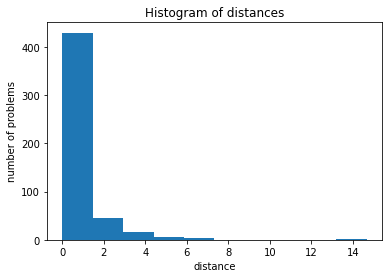

In [ ]:
# plots the disribution of optimal distances
romc.distance_hist()

In [ ]:
eps_filter = .75
fit_models = True
fit_models_args = {"nof_points":30}
romc.estimate_regions(eps_filter=eps_filter, fit_models=fit_models, fit_models_args=fit_models_args)

Building boxes
Progress [==================================================] 100.0% Complete
Fitting models
Progress [==================================================] 100.0% Complete


 /usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


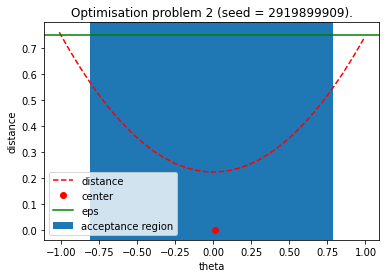

In [ ]:
romc.visualize_region(2)

## Inference

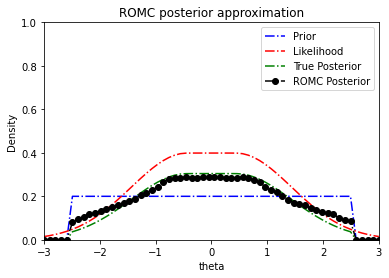

In [ ]:
# make plot
plt.figure()
plt.title("ROMC posterior approximation")
plt.xlim(-3, 3)
plt.xlabel("theta")
plt.ylabel("Density")
plt.ylim(0, 1)

# plot prior
theta = np.linspace(-3, 3, 60)
y = prior.pdf(theta)
plt.plot(theta, y, 'b-.', label='Prior')

# plot likelihood
y = likelihood.pdf(x=data, theta=theta)
plt.plot(theta, y, 'r-.', label='Likelihood')

# plot posterior
y = np.squeeze(np.array([gt_posterior_pdf(th) for th in theta]))
plt.plot(theta, y, 'g-.', label="True Posterior")

# plot ROMC posterior
y = [romc.eval_posterior(np.array([[th]])) for th in theta]
tmp = np.squeeze(np.array(y))
plt.plot(theta, tmp, 'k-.o', label="ROMC Posterior")

plt.legend()
plt.show(block=False)

In [ ]:
n2 = 200
tmp = romc.sample(n2=n2)

Sampling posterior regions
Progress [==================================================] 100.0% Complete


 /usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


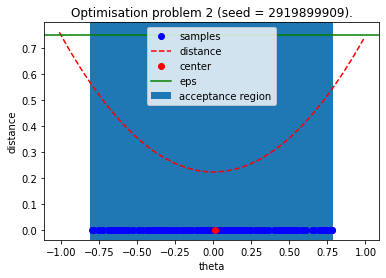

In [ ]:
# As before but now it plots the samples as well
romc.visualize_region(2)

In [ ]:
# compute expectation
print("Expected mean    : %.3f, ground-truth: %.3f" % (romc.compute_expectation(h = lambda x: np.squeeze(x)), gt_posterior_mean))
print("Expected variance: %.3f, ground-truth: %.3f" % (romc.compute_expectation(h =lambda x: np.squeeze(x)**2), gt_posterior_var))

Expected mean    : -0.011, ground-truth: 0.000
Expected variance: 1.132, ground-truth: 1.100


## Evaluation of the inference

In [ ]:
# compute divergence
def wrapper(x):
    """gt_posterior_pdf with batching.
    """
    res = []
    for i in range(x.shape[0]):
        tmp = x[i]
        res.append(gt_posterior_pdf(float(tmp)))
    return np.array(res)

print("Divergence from ground-truth, using Jensen-Shannon distance: %.3f" % romc.compute_divergence(wrapper, distance="Jensen-Shannon"))

Divergence from ground-truth, using Jensen-Shannon distance: 0.070


In [ ]:
# compute ESS
print("Nof Samples: %d, ESS: %.3f" % (len(romc.result.weights), romc.compute_ess()))

Nof Samples: 77200, ESS: 64743.294


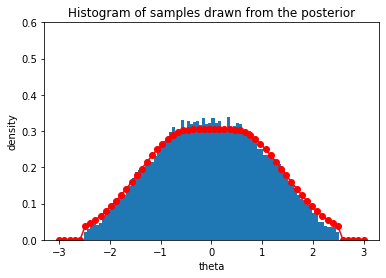

In [ ]:
# plot histogram of samples
plt.figure()
plt.title("Histogram of samples drawn from the posterior")
plt.hist(romc.result.samples_array, weights=romc.result.weights, bins=100, density=True, range=(-3,3))

theta = np.linspace(-3, 3, 60)
y = np.squeeze(np.array([gt_posterior_pdf(th) for th in theta]))
plt.plot(theta, y, 'r-o', label="True Posterior")

plt.ylim([0, .6])
plt.xlabel('theta')
plt.ylabel('density')
plt.show()

## Ιdeas for the future 

### TODO

#### ASAP:
* Add GT information on the expected mean, std (approx computationaly)

* add inspection plot; nof_samples vs epsilon

* make a plot ESS vs epsilon after the samples have been drawn

* ~add passing the gradients in closed form~

* ~slightly change the compute regions part~

* ~make eps_cutoff, eps two different quantities; set eps=eps_cutoff as a default option~

* ~based on the drawn samples, plot ESS vs eps~

* ~plot_pairs with GT information, check how plot pairs is implemented (maybe weights are not passed well)~

* ~add some functionalities for checking the posterior's correctness, if the user can provide a Ground truth (as in the example). Such, ideas could be: Jensen-Shannon, KL-Divergence, Euclidean Distance~

* ~pass arguments at theta_hist~

* ~add function for compute_ESS~

#### Future Ideas:

* parallelize the procedure. Make it possible for the algorithm to use all the cores of the cpu, when solving the optimisation problems and when computing the bounding box areas.

* Try to find a clever way of reusing/recycling previous computations when we change epsilon

* Sample from a multivariate gaussian (with zero-covariances) instead of a Uniform (iff the region is defined as a single Bounding Box, this is easy)

* Approximate the Bounding Box region with many Bounding boxes instead of only one.





# Training part, using Bayesian Optimisation

We repeat the same procedure as before, using the Bayesian optimisation scheme. We will use less optimisation problems (n1=100), because the solving them is more time consuming using Bayesian Optimisation.

In [ ]:
# Define and solve n1 optimisation problems
n1 = 100
seed = 21
optimizer_args = {}
use_bo=True
romc.solve_problems(n1=n1, seed=seed, use_bo=use_bo, optimizer_args=optimizer_args)

 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /usr/local/lib/python3.6/dist-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /usr/local/lib/python3.6/dist-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1
 /usr/local/lib/python3.6/dist-packages/GPy/core/parameterization/priorizable.py:81: RuntimeWarning:overflow encountered in double_scalars


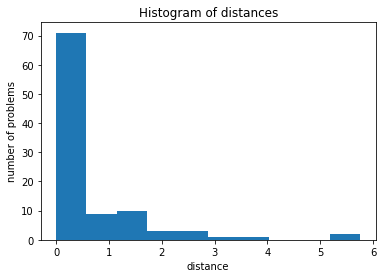

In [ ]:
# plots the disribution of optimal distances
romc.distance_hist()

In [ ]:
eps_filter = .75
fit_models = True
fit_models_args = {"nof_points":30}
romc.estimate_regions(eps_filter=eps_filter, fit_models=fit_models, fit_models_args=fit_models_args)

 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide


 /usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


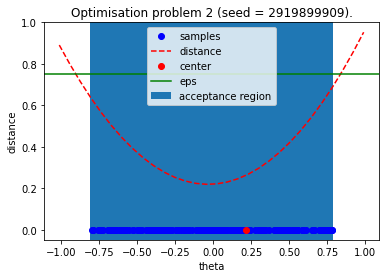

In [ ]:
romc.visualize_region(2)

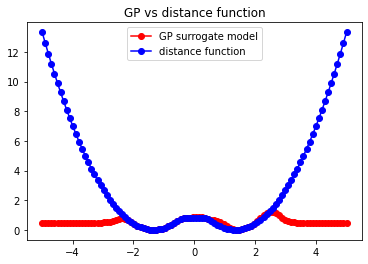

In [ ]:
# check how the Gaussian Process surrogate model approximates the distance function
tmp = romc.optim_problems[2]
x = np.linspace(-5, 5, 100)
y1 = [tmp.surrogate(np.atleast_1d(ii)) for ii in x]
y2 = [tmp.objective(np.atleast_1d(ii)) for ii in x]

plt.figure()
plt.title("GP vs distance function")
plt.plot(x, y1, "r-o", label="GP surrogate model")
plt.plot(x, y2, "b-o", label="distance function")
plt.legend()
plt.show()

## Inference

In [ ]:
theta = np.array([[0.]])
print("Posterior evaluation: f(theta=%.3f)=%.3f" %(theta, romc.eval_posterior(theta=theta)))

Posterior evaluation: f(theta=0.000)=0.302


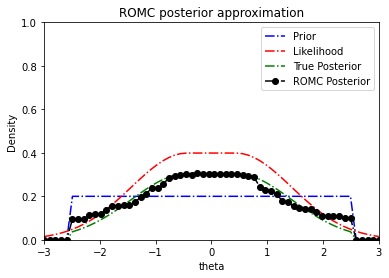

In [ ]:
# romc.romc_posterior.eps_cutoff = 1.5
# romc.romc_posterior.partition = None

# make plot
plt.figure()
plt.title("ROMC posterior approximation")
plt.xlim(-3, 3)
plt.xlabel("theta")
plt.ylabel("Density")
plt.ylim(0, 1)

# plot prior
theta = np.linspace(-3, 3, 60)
y = prior.pdf(theta)
plt.plot(theta, y, 'b-.', label='Prior')

# plot likelihood
y = likelihood.pdf(x=data, theta=theta)
plt.plot(theta, y, 'r-.', label='Likelihood')

# plot posterior
y = np.squeeze(np.array([gt_posterior_pdf(th) for th in theta]))
plt.plot(theta, y, 'g-.', label="True Posterior")

# plot ROMC posterior
y = [romc.eval_posterior(np.array([[th]])) for th in theta]
tmp = np.squeeze(np.array(y))
plt.plot(theta, tmp, 'k-.o', label="ROMC Posterior")

plt.legend()
plt.show(block=False)

In [ ]:
n2 = 300
tmp = romc.sample(n2=n2)

 /usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


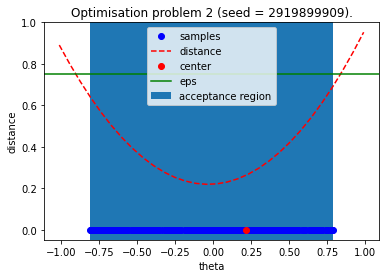

In [ ]:
# As before but now it plots the samples as well
romc.visualize_region(2)

In [ ]:
# compute expectation
print("Expected mean    : %.3f, ground-truth: %.3f" % (romc.compute_expectation(h = lambda x: np.squeeze(x)), gt_posterior_mean))
print("Expected variance: %.3f, ground-truth: %.3f" % (romc.compute_expectation(h =lambda x: np.squeeze(x)**2), gt_posterior_var))

Expected mean    : -0.008, ground-truth: 0.000
Expected variance: 1.070, ground-truth: 1.100


## Evaluation of the inference

In [ ]:
# compute divergence
def wrapper(x):
    """gt_posterior_pdf with batching.
    """
    res = []
    for i in range(x.shape[0]):
        tmp = x[i]
        res.append(gt_posterior_pdf(float(tmp)))
    return np.array(res)

print("Divergence from ground-truth, using Jensen-Shannon distance: %.3f" % romc.compute_divergence(wrapper, distance="Jensen-Shannon"))

Divergence from ground-truth, using Jensen-Shannon distance: 0.072


In [ ]:
# compute ESS
print("Nof Samples: %d, ESS: %.3f" % (len(romc.result.weights), romc.compute_ess()))

Nof Samples: 22200, ESS: 4198.216


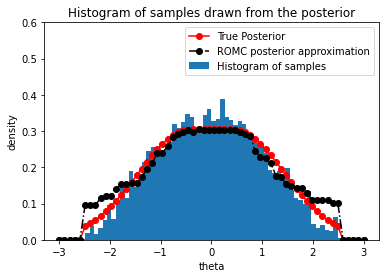

In [ ]:
# plot histogram of samples
plt.figure()
plt.title("Histogram of samples drawn from the posterior")
plt.hist(romc.result.samples_array, weights=romc.result.weights, bins=70, density=True, range=(-3,3), label="Histogram of samples")

theta = np.linspace(-3, 3, 60)
y = np.squeeze(np.array([gt_posterior_pdf(th) for th in theta]))
plt.plot(theta, y, 'r-o', label="True Posterior")

y = [romc.eval_posterior(np.array([[th]])) for th in theta]
tmp = np.squeeze(np.array(y))
plt.plot(theta, tmp, 'k-.o', label="ROMC posterior approximation")

plt.ylim([0, .6])
plt.xlabel('theta')
plt.ylabel('density')
plt.legend()
plt.show()